Simple Gaussian Process Model Using Oscillatory Decay Function

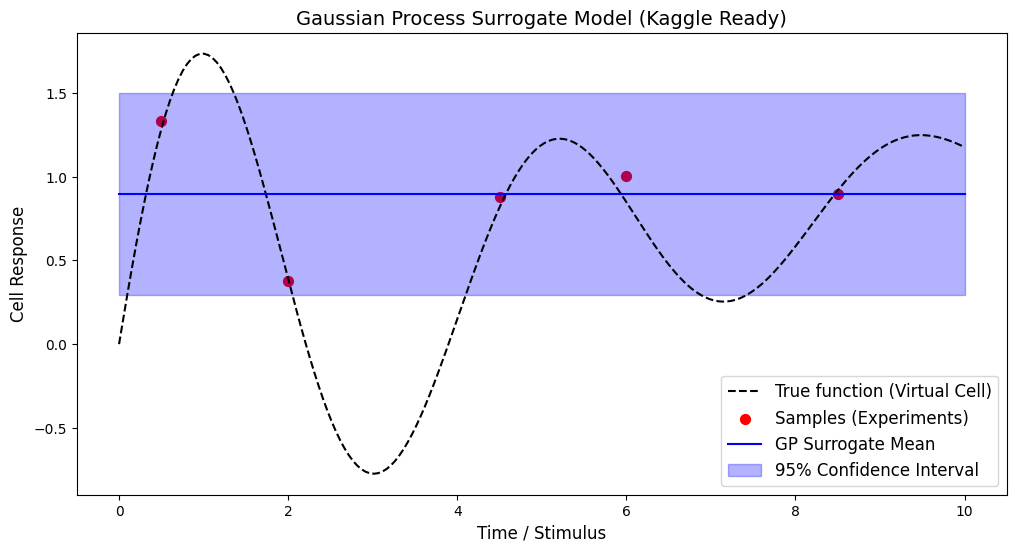

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# -----------------------------
# Step 1: Define "virtual cell" function (toy example)
# Replace this later with your dataset / simulator
# -----------------------------
def virtual_cell(x):
    # Oscillatory decay function (mimics cell behavior)
    return 2.0 * np.sin(1.5 * x) * np.exp(-0.2 * x) + 0.1 * x

# -----------------------------
# Step 2: Generate synthetic training data
# -----------------------------
np.random.seed(42)  # reproducibility
X_train = np.array([[0.5], [2.0], [4.5], [6.0], [8.5]])  # "experiments"
y_train = virtual_cell(X_train).ravel() + 0.1 * np.random.randn(len(X_train))  # noisy obs

# Test data (dense grid)
X_test = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = virtual_cell(X_test).ravel()

# -----------------------------
# Step 3: Define GP Kernel & Model
# -----------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-2)

gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=5,
                              normalize_y=True,
                              random_state=42)

# Fit GP surrogate
gp.fit(X_train, y_train)

# Predictions with uncertainty
y_mean, y_std = gp.predict(X_test, return_std=True)

# -----------------------------
# Step 4: Plot results
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_true, "k--", label="True function (Virtual Cell)")
plt.scatter(X_train, y_train, c="red", s=50, label="Samples (Experiments)")
plt.plot(X_test, y_mean, "b", label="GP Surrogate Mean")
plt.fill_between(X_test.ravel(),
                 y_mean - 1.96 * y_std,
                 y_mean + 1.96 * y_std,
                 alpha=0.3,
                 color="blue",
                 label="95% Confidence Interval")

plt.legend(fontsize=12)
plt.xlabel("Time / Stimulus", fontsize=12)
plt.ylabel("Cell Response", fontsize=12)
plt.title("Gaussian Process Surrogate Model (Kaggle Ready)", fontsize=14)
plt.show()

Simple Gaussian Process Model Using Oscillatory Decay Function with Active Learning

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

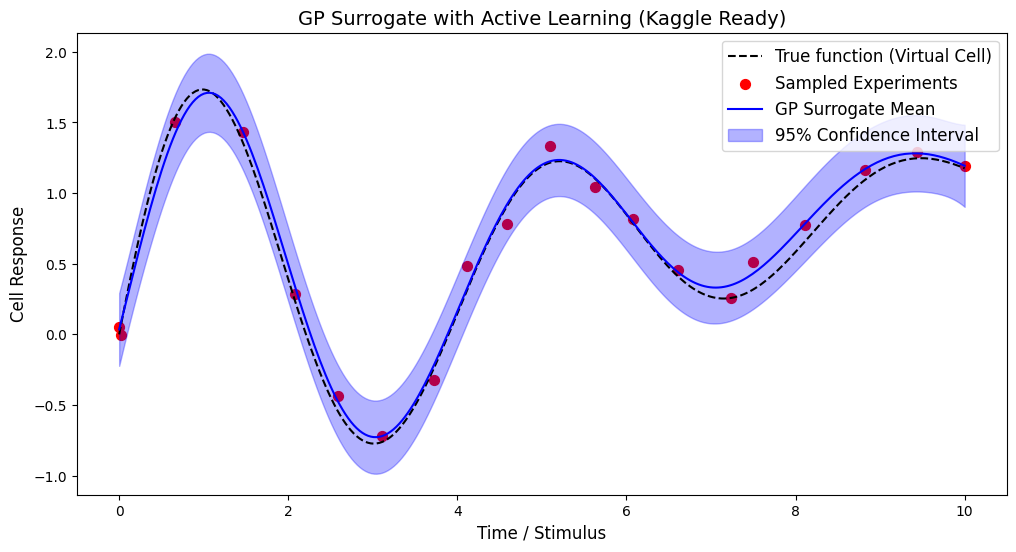

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# -----------------------------
# Step 1: Define "virtual cell" function (toy example)
# -----------------------------
def virtual_cell(x):
    # Oscillatory decay (like protein concentration over time)
    return 2.0 * np.sin(1.5 * x) * np.exp(-0.2 * x) + 0.1 * x

# -----------------------------
# Step 2: Candidate pool (possible experiments)
# -----------------------------
X_pool = np.linspace(0, 10, 500).reshape(-1, 1)   # candidate inputs
y_true_pool = virtual_cell(X_pool).ravel()        # "oracle"

# Initial labeled samples (seed experiments)
np.random.seed(42)
init_idx = np.random.choice(len(X_pool), size=5, replace=False)
X_train = X_pool[init_idx]
y_train = y_true_pool[init_idx] + 0.1 * np.random.randn(len(init_idx))

# -----------------------------
# Step 3: Define GP model
# -----------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-2)

gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=5,
                              normalize_y=True,
                              random_state=42)

# -----------------------------
# Step 4: Active Learning Loop
# -----------------------------
budget = 20   # total experiments allowed (including initial)
history_rmse = []

for it in range(budget - len(X_train)):
    # Fit GP on current data
    gp.fit(X_train, y_train)
    
    # Predict on pool
    mu, std = gp.predict(X_pool, return_std=True)
    
    # Mask already-labeled points
    labeled_mask = np.isin(X_pool.ravel(), X_train.ravel())
    std[labeled_mask] = -1.0
    
    # Pick most uncertain point (max variance)
    next_idx = np.argmax(std)
    x_next = X_pool[next_idx].reshape(1, -1)
    y_next = virtual_cell(x_next).ravel()[0] + 0.1 * np.random.randn()
    
    # Add to training data
    X_train = np.vstack([X_train, x_next])
    y_train = np.append(y_train, y_next)

# -----------------------------
# Step 5: Final Model & Visualization
# -----------------------------
gp.fit(X_train, y_train)
X_test = np.linspace(0, 10, 300).reshape(-1, 1)
y_true = virtual_cell(X_test).ravel()
y_mean, y_std = gp.predict(X_test, return_std=True)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_true, "k--", label="True function (Virtual Cell)")
plt.scatter(X_train, y_train, c="red", s=50, label="Sampled Experiments")
plt.plot(X_test, y_mean, "b", label="GP Surrogate Mean")
plt.fill_between(X_test.ravel(),
                 y_mean - 1.96 * y_std,
                 y_mean + 1.96 * y_std,
                 alpha=0.3,
                 color="blue",
                 label="95% Confidence Interval")

plt.legend(fontsize=12)
plt.xlabel("Time / Stimulus", fontsize=12)
plt.ylabel("Cell Response", fontsize=12)
plt.title("GP Surrogate with Active Learning (Kaggle Ready)", fontsize=14)
plt.show()


GP Model for oscillatory decay function + active learning + latin hypercube sampling


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:

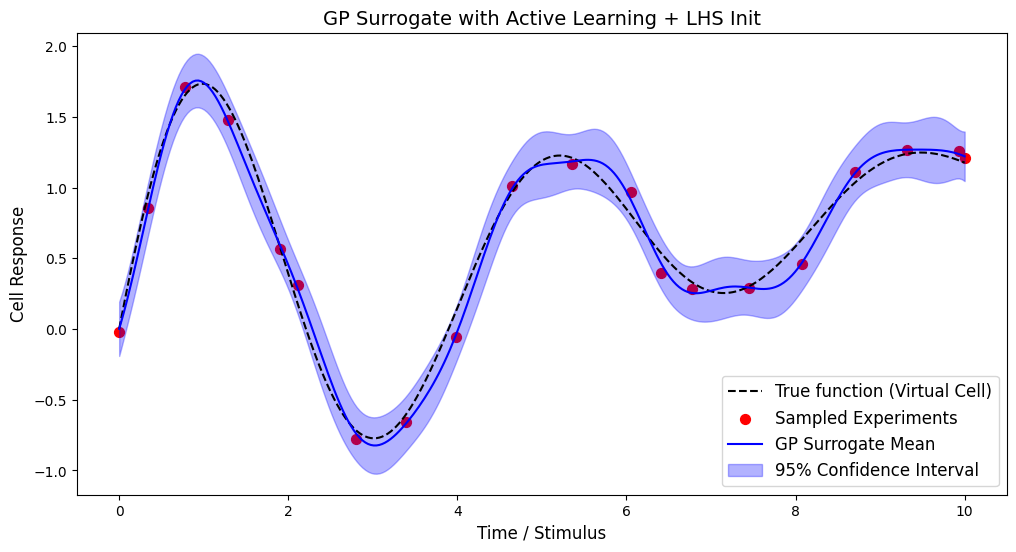

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import qmc   # for Latin Hypercube Sampling

# -----------------------------
# Step 1: Define "virtual cell" function (toy example)
# -----------------------------
def virtual_cell(x):
    # Oscillatory decay (like protein concentration over time)
    return 2.0 * np.sin(1.5 * x) * np.exp(-0.2 * x) + 0.1 * x

# -----------------------------
# Step 2: Candidate pool (possible experiments)
# -----------------------------
X_pool = np.linspace(0, 10, 500).reshape(-1, 1)   # candidate inputs
y_true_pool = virtual_cell(X_pool).ravel()        # "oracle"

# -----------------------------
# Step 2.1: Initial labeled samples with LHS
# -----------------------------
np.random.seed(42)
sampler = qmc.LatinHypercube(d=1)   # 1D problem here
lhs_samples = sampler.random(n=5)   # pick 5 initial points
X_train = qmc.scale(lhs_samples, 0, 10).reshape(-1, 1)  # scale to [0, 10]
y_train = virtual_cell(X_train).ravel() + 0.1 * np.random.randn(len(X_train))

# -----------------------------
# Step 3: Define GP model
# -----------------------------
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-2)

gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=5,
                              normalize_y=True,
                              random_state=42)

# -----------------------------
# Step 4: Active Learning Loop
# -----------------------------
budget = 20   # total experiments allowed (including initial)

for it in range(budget - len(X_train)):
    # Fit GP on current data
    gp.fit(X_train, y_train)
    
    # Predict on pool
    mu, std = gp.predict(X_pool, return_std=True)
    
    # Mask already-labeled points
    labeled_mask = np.isin(X_pool.ravel(), np.round(X_train.ravel(), 3))
    std[labeled_mask] = -1.0
    
    # Pick most uncertain point (max variance)
    next_idx = np.argmax(std)
    x_next = X_pool[next_idx].reshape(1, -1)
    y_next = virtual_cell(x_next).ravel()[0] + 0.1 * np.random.randn()
    
    # Add to training data
    X_train = np.vstack([X_train, x_next])
    y_train = np.append(y_train, y_next)

# -----------------------------
# Step 5: Final Model & Visualization
# -----------------------------
gp.fit(X_train, y_train)
X_test = np.linspace(0, 10, 300).reshape(-1, 1)
y_true = virtual_cell(X_test).ravel()
y_mean, y_std = gp.predict(X_test, return_std=True)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_true, "k--", label="True function (Virtual Cell)")
plt.scatter(X_train, y_train, c="red", s=50, label="Sampled Experiments")
plt.plot(X_test, y_mean, "b", label="GP Surrogate Mean")
plt.fill_between(X_test.ravel(),
                 y_mean - 1.96 * y_std,
                 y_mean + 1.96 * y_std,
                 alpha=0.3,
                 color="blue",
                 label="95% Confidence Interval")

plt.legend(fontsize=12)
plt.xlabel("Time / Stimulus", fontsize=12)
plt.ylabel("Cell Response", fontsize=12)
plt.title("GP Surrogate with Active Learning + LHS Init", fontsize=14)
plt.show()


GP Model for MAPK/ERK Pathway + active learning + latin hypercube sampling

Initial labeled points: 8
Iteration 1/72 — labeled: 9 — test RMSE: 0.0938
Iteration 10/72 — labeled: 18 — test RMSE: 0.0606
Iteration 20/72 — labeled: 28 — test RMSE: 0.0739
Iteration 30/72 — labeled: 38 — test RMSE: 0.0412
Iteration 40/72 — labeled: 48 — test RMSE: 0.0226
Iteration 50/72 — labeled: 58 — test RMSE: 0.0208
Iteration 60/72 — labeled: 68 — test RMSE: 0.0186
Iteration 70/72 — labeled: 78 — test RMSE: 0.0174

Final test RMSE after active learning: 0.0147


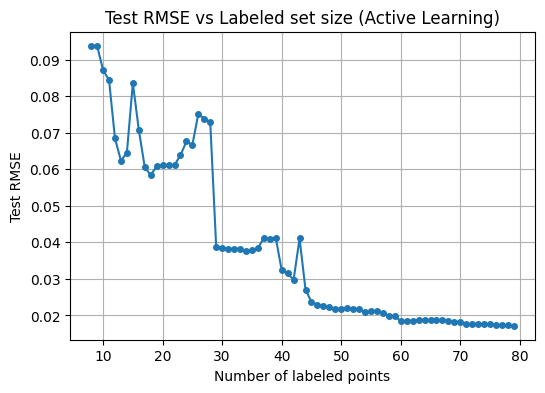

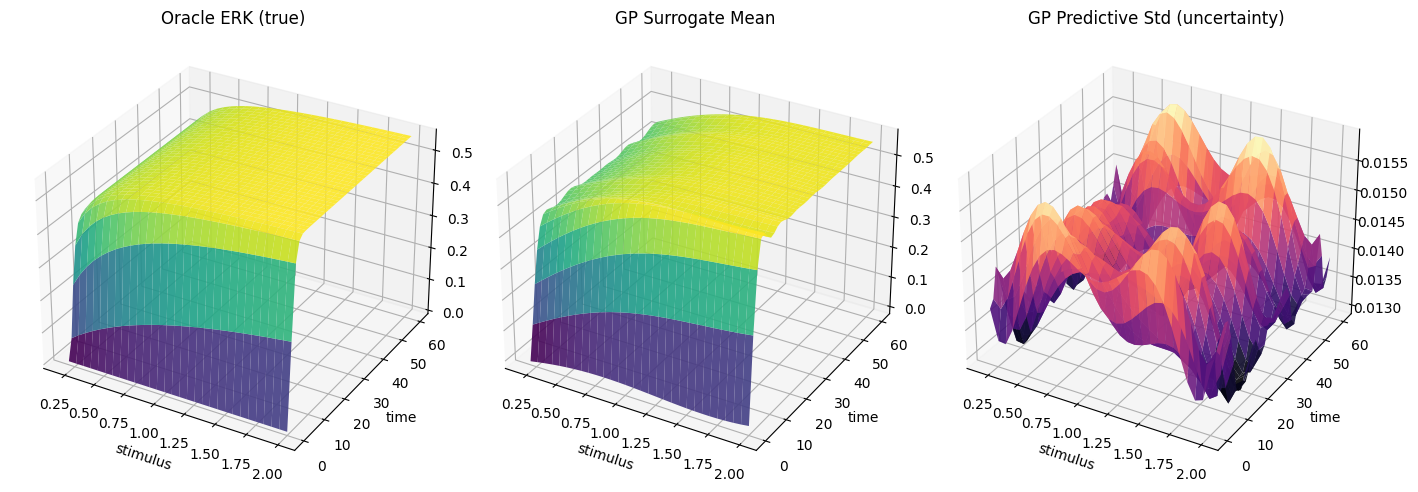

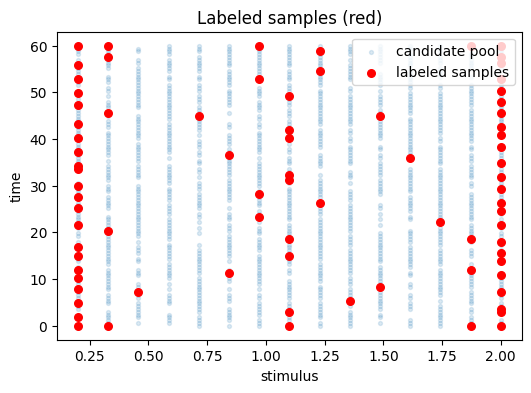

Saved mapk_erk_active_labeled.csv


In [2]:
# GP surrogate + Active Learning pipeline for MAPK/ERK simulated data
# Run in Kaggle/Colab/local. Python 3.8+, scikit-learn, scipy required.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")  # suppress sklearn convergence warnings for clarity

RNG = np.random.default_rng(0)

# -------------------------
# 1) Simple MAPK/ERK simulator (as used before)
# -------------------------
def mapk_erk_ode(t, y, params):
    RAS_active, RAF_active, MEK_active, ERK_active = y
    k1, k2, k3, k4, k5, k6 = params
    dRAS = 0.0
    dRAF = k1 * RAS_active * (1 - RAF_active) - k2 * RAF_active
    dMEK = k3 * RAF_active * (1 - MEK_active) - k4 * MEK_active
    dERK = k5 * MEK_active * (1 - ERK_active) - k6 * ERK_active
    return [dRAS, dRAF, dMEK, dERK]

params_base = [1.0, 0.5, 1.2, 0.6, 1.0, 0.5]

def simulate_pathway(stimulus_level, t_end=60, num_points=101):
    y0 = [stimulus_level, 0.0, 0.0, 0.0]
    t_eval = np.linspace(0, t_end, num_points)
    sol = solve_ivp(mapk_erk_ode, [0, t_end], y0, args=(params_base,), t_eval=t_eval, method='RK45', rtol=1e-7)
    return t_eval, sol.y  # sol.y shape (4, n_timepoints)

# -------------------------
# 2) Build a dense candidate pool (stimulus × time grid) and generate "oracle" labels
# -------------------------
stimulus_space = np.linspace(0.2, 2.0, 15)   # 15 stimulus levels (can expand)
time_space = np.linspace(0, 60, 101)         # 101 time points (0..60)
pool_list = []
for s in stimulus_space:
    t_eval, y = simulate_pathway(s, t_end=60, num_points=len(time_space))
    erk = y[3]  # ERK_active
    for ti, tr in zip(t_eval, erk):
        pool_list.append((s, ti, tr))
pool_df = pd.DataFrame(pool_list, columns=["stimulus", "time", "ERK_active"])

# Shuffle pool to avoid ordered biases (but keep indices)
pool_df = pool_df.sample(frac=1, random_state=0).reset_index(drop=True)

# -------------------------
# 3) Train/test split on the pool (hold out test set for evaluation)
# -------------------------
test_frac = 0.2
n_total = len(pool_df)
n_test = int(np.floor(test_frac * n_total))
test_df = pool_df.iloc[:n_test].reset_index(drop=True)
pool_df = pool_df.iloc[n_test:].reset_index(drop=True)  # remaining points will be pool for active learning

# We'll use pool_df as candidate pool whose labels are known (oracle) but we pretend unlabeled
X_pool = pool_df[["stimulus", "time"]].values
y_pool = pool_df["ERK_active"].values
X_test = test_df[["stimulus", "time"]].values
y_test = test_df["ERK_active"].values

# -------------------------
# 4) Initial labeled set via Latin Hypercube Sampling (LHS) over stimulus × time ranges
# -------------------------
n_initial = 8
sampler = qmc.LatinHypercube(d=2, seed=0)
lhs = sampler.random(n_initial)
# scale: stimulus in [min, max], time in [min, max]
stim_min, stim_max = float(pool_df["stimulus"].min()), float(pool_df["stimulus"].max())
time_min, time_max = float(pool_df["time"].min()), float(pool_df["time"].max())
lhs_scaled = qmc.scale(lhs, [stim_min, time_min], [stim_max, time_max])
lhs_stim, lhs_time = lhs_scaled[:,0], lhs_scaled[:,1]
lhs_points = np.column_stack([lhs_stim, lhs_time])

# For initial labeled set, pick nearest points from pool_df to these LHS points
def find_nearest_indices(pool_X, query_X):
    # pool_X: (N,2), query_X: (k,2) -> return list of nearest pool indices (unique)
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1).fit(pool_X)
    dists, idxs = nn.kneighbors(query_X)
    return idxs.ravel().tolist()

initial_idxs = find_nearest_indices(X_pool, lhs_points)
initial_idxs = list(dict.fromkeys(initial_idxs))  # unique while preserving order

X_train = X_pool[initial_idxs]
y_train = y_pool[initial_idxs]

# Mark labeled indices
labeled_mask = np.zeros(len(X_pool), dtype=bool)
labeled_mask[initial_idxs] = True

print(f"Initial labeled points: {len(initial_idxs)}")

# -------------------------
# 5) Preprocessing: scale inputs (important for ARD kernels)
# -------------------------
scaler_X = StandardScaler()
# Fit scaler on entire pool (so scaling consistent for test / pool)
scaler_X.fit(X_pool)
X_pool_s = scaler_X.transform(X_pool)
X_train_s = scaler_X.transform(X_train)
X_test_s = scaler_X.transform(X_test)

# -------------------------
# 6) GP model (ARD RBF + WhiteKernel). Use sensible noise bounds
# -------------------------
n_features = X_pool_s.shape[1]
length_init = np.ones(n_features)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_init, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-8, 1e1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)

# -------------------------
# 7) Active Learning Loop (uncertainty sampling)
# -------------------------
budget_total = 80               # total labeled points desired (including initial)
n_iterations = budget_total - X_train_s.shape[0]
history = {"n_labeled": [], "rmse_test": []}

for it in range(n_iterations):
    # Fit GP on current labeled set
    gp.fit(X_train_s, y_train)
    # Evaluate on test set
    y_test_pred, y_test_std = gp.predict(X_test_s, return_std=True)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    history["n_labeled"].append(X_train_s.shape[0])
    history["rmse_test"].append(rmse)
    # Predict on the unlabeled pool
    mu_pool, std_pool = gp.predict(X_pool_s, return_std=True)
    # Mask already labeled points
    std_pool[labeled_mask] = -1.0
    # Select most uncertain point (highest std)
    next_idx = int(np.argmax(std_pool))
    # Add it
    X_next = X_pool[next_idx:next_idx+1]
    y_next = y_pool[next_idx:next_idx+1]
    # append to training arrays
    X_train = np.vstack([X_train, X_next])
    y_train = np.concatenate([y_train, y_next])
    X_train_s = scaler_X.transform(X_train)
    # mark labeled
    labeled_mask[next_idx] = True

    if (it+1) % 10 == 0 or it == 0:
        print(f"Iteration {it+1}/{n_iterations} — labeled: {X_train_s.shape[0]} — test RMSE: {rmse:.4f}")

# Final fit
gp.fit(X_train_s, y_train)
y_test_pred, y_test_std = gp.predict(X_test_s, return_std=True)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nFinal test RMSE after active learning: {final_rmse:.4f}")

# -------------------------
# 8) Visualizations
# -------------------------
# (A) RMSE vs labeled count
plt.figure(figsize=(6,4))
plt.plot(history["n_labeled"], history["rmse_test"], '-o', markersize=4)
plt.xlabel("Number of labeled points")
plt.ylabel("Test RMSE")
plt.title("Test RMSE vs Labeled set size (Active Learning)")
plt.grid(True)
plt.show()

# (B) True ERK surface and GP predictions (for visualization we'll sample a coarser grid)
stim_grid = np.linspace(stim_min, stim_max, 30)
time_grid = np.linspace(time_min, time_max, 40)
SG, TG = np.meshgrid(stim_grid, time_grid)
grid_pts = np.column_stack([SG.ravel(), TG.ravel()])
grid_pts_s = scaler_X.transform(grid_pts)
mu_grid, std_grid = gp.predict(grid_pts_s, return_std=True)

# actual (oracle) on the same grid: simulate for each stimulus and extract time values
oracle_vals = []
for (s, t) in grid_pts:
    # find nearest in pool_df (pool had dense sim)
    # simpler: re-run simulation for s and sample at t
    t_eval, yvals = simulate_pathway(s, t_end=time_max, num_points=201)
    # nearest time index
    t_idx = np.argmin(np.abs(t_eval - t))
    oracle_vals.append(yvals[3][t_idx])
oracle_vals = np.array(oracle_vals)

# reshape
MU = mu_grid.reshape(SG.shape)
STD = std_grid.reshape(SG.shape)
ORACLE = oracle_vals.reshape(SG.shape)

# plot predicted mean surface
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(SG, TG, ORACLE, cmap='viridis', alpha=0.9)
ax1.set_title('Oracle ERK (true)'); ax1.set_xlabel('stimulus'); ax1.set_ylabel('time')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(SG, TG, MU, cmap='viridis', alpha=0.9)
ax2.set_title('GP Surrogate Mean'); ax2.set_xlabel('stimulus'); ax2.set_ylabel('time')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(SG, TG, STD, cmap='magma', alpha=0.9)
ax3.set_title('GP Predictive Std (uncertainty)'); ax3.set_xlabel('stimulus'); ax3.set_ylabel('time')

plt.tight_layout()
plt.show()

# (C) Show sampled labeled points on the stimulus-time plane
labeled_pts = X_train  # final labeled points (original scale)
plt.figure(figsize=(6,4))
plt.scatter(X_pool[:,0], X_pool[:,1], s=8, alpha=0.15, label='candidate pool')
plt.scatter(labeled_pts[:,0], labeled_pts[:,1], c='red', s=30, label='labeled samples')
plt.xlabel('stimulus'); plt.ylabel('time'); plt.legend(); plt.title('Labeled samples (red)')
plt.show()

# -------------------------
# 9) Save the labeled training dataset and GP (optional)
# -------------------------
train_df = pd.DataFrame(X_train, columns=['stimulus','time'])
train_df['ERK_active'] = y_train
train_df.to_csv("mapk_erk_active_labeled.csv", index=False)
print("Saved mapk_erk_active_labeled.csv")
